# Cluster Analysis

In [98]:
# Clustering test script for short static task

import csv
import pandas as pd
import numpy as np
import scipy as sp
import statistics
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from mpl_toolkits.mplot3d import Axes3D
from sklearn import metrics
from sklearn.cluster import KMeans
import matplotlib.cm as cm
from statsmodels.stats import weightstats as stests
from statsmodels.formula.api import ols
pd.set_option('display.max_rows', 2000)

import statsmodels.api as sm
from statsmodels.nonparametric.smoothers_lowess import lowess

## Setup

In [99]:
# Raw data filename
shortpath = Path(r"C:/Users/bbio/Documents/GrazianoLab/4-Correlates_of_Social_Cognition/shortened_static_awareness_task/data")
fn1 = "SSAT_070820_203subs.xlsx"
fn2 = "SSAT_RMET_HT_5.xlsx"

# Import data csv
df1_raw = pd.read_excel(shortpath / fn1,sheet_name="data",usecols="A:IF")
df2_raw = pd.read_excel(shortpath / fn2,sheet_name="SSAT",usecols="A:IF")
rmet1_raw = pd.read_excel(shortpath / fn1,sheet_name="rmet")
rmet2_raw = pd.read_excel(shortpath / fn2,sheet_name="RMET")
ht_raw = pd.read_excel(shortpath / fn2,sheet_name="HT",usecols="C")
#hte_raw = pd.read_excel(shortpath / fn2,sheet_name="HT_eval1",usecols="A")
hte_raw = pd.read_excel(shortpath / fn2,sheet_name="HT_WC1",usecols="A:B")

# Copy raw data to manipulate
df_temp = pd.concat([df1_raw,df2_raw],axis=0)
df_temp = df_temp.reset_index(drop=True)
rmet_temp = pd.concat([rmet1_raw,rmet2_raw],axis=0)
rmet_temp = rmet_temp.reset_index(drop=True)
#df_temp = pd.concat([df2_raw,rmet2_raw],axis=1)
ht_pretemp = pd.concat([ht_raw,hte_raw],axis=1)

naDiff = pd.to_numeric(rmet_temp.shape[0] - ht_pretemp.shape[0])

#df_na = pd.DataFrame(np.nan, index=range(0,naDiff), columns=['ht','ht_eval'])
df_na = pd.DataFrame(np.nan, index=range(0,naDiff), columns=['ht','ht_eval','WC_Avg'])

ht_temp = pd.concat([df_na,ht_pretemp],axis=0)
ht_temp = ht_temp.reset_index(drop=True)

# Copy raw data to manipulate
combined = pd.concat([df_temp,rmet_temp,ht_temp],axis=1)
combined = combined.reset_index(drop=True)

In [100]:
combined.shape

(831, 244)

In [101]:
combined

,chalk_AAC,wine_ATC,door_HAI,tsunami_ATC,sinkhole_AAC,building_HTI,carcrash_HAI,hurricane_HTI,spider_ATC,rottenorange_AAC,...,gift_HAC,flowers_ATI,tree_AAI,rose_AAI,sunbeam_HTC,sunbeam_HAC,rmet,ht,ht_eval,WC_Avg
0,Very Aware,Somewhat Aware,Somewhat Aware,Somewhat Aware,Very Aware,Somewhat Aware,Very Aware,Somewhat Aware,Somewhat Aware,Very Aware,...,Somewhat Aware,Somewhat Aware,Somewhat Aware,Very Aware,Somewhat Aware,Very Aware,8,NaN,NaN,NaN
1,Very Aware,Very Aware,Not Aware,Very Aware,Not Aware,Somewhat Aware,Not Aware,Somewhat Aware,Very Aware,Somewhat Aware,...,Somewhat Aware,Somewhat Aware,Not Aware,Not Aware,Very Aware,Somewhat Aware,32,NaN,NaN,NaN
2,Not Aware,Very Aware,Not Aware,Very Aware,Not Aware,Somewhat Aware,Not Aware,NaN,Very Aware,Somewhat Aware,...,Somewhat Aware,Not Aware,Not Aware,Not Aware,Very Aware,Somewhat Aware,30,NaN,NaN,NaN
3,Somewhat Aware,Not Aware,NaN,NaN,Not Aware,Very Aware,NaN,NaN,Somewhat Aware,NaN,...,Very Aware,Not Aware,NaN,Not Aware,Very Aware,Very Aware,15,NaN,NaN,NaN
4,Not Aware,Very Aware,Not Aware,Very Aware,Not Aware,Very Aware,Not Aware,Very Aware,Very Aware,Not Aware,...,Somewhat Aware,Not Aware,Not Aware,Not Aware,Not Aware,Not Aware,34,NaN,NaN,NaN
5,Not Aware,NaN,NaN,NaN,NaN,Somewhat Aware,Not Aware,Very Aware,Somewhat Aware,NaN,...,Not Aware,NaN,NaN,Not Aware,Somewhat Aware,Not Aware,21,NaN,NaN,NaN
6,Not Aware,Somewhat Aware,NaN,Somewhat Aware,Not Aware,Somewhat Aware,Somewhat Aware,Very Aware,Somewhat Aware,Not Aware,...,NaN,NaN,Not Aware,NaN,Very Aware,Not Aware,23,NaN,NaN,NaN
7,Somewhat Aware,Very Aware,Somewhat Aware,Somewhat Aware,Somewhat Aware,Somewhat Aware,Somewhat Aware,Very Aware,Somewhat Aware,Not Aware,...,Very Aware,Very Aware,Somewhat Aware,Somewhat Aware,Very Aware,Somewhat Aware,12,NaN,NaN,NaN
8,Not Aware,Very Aware,Not Aware,Very Aware,Somewhat Aware,Not Aware,Not Aware,Not Aware,Very Aware,Somewhat Aware,...,Not Aware,Not Aware,Not Aware,Not Aware,Very Aware,Somewhat Aware,24,NaN,NaN,NaN
9,Somewhat Aware,Somewhat Aware,Not Aware,Somewhat Aware,Somewhat Aware,Very Aware,Not Aware,Very Aware,Somewhat Aware,Somewhat Aware,...,Not Aware,Somewhat Aware,Somewhat Aware,Somewhat Aware,Very Aware,Not Aware,20,NaN,NaN,NaN


In [102]:
# Create subject list
subs = []

# Count subs
subCount = len(combined.index)

for x in range(1,subCount + 1):
    if x < 10:
        tmp = "s00" + str(x)
    elif 9 < x < 100:
        tmp = "s0" + str(x)
    elif x > 99: 
        tmp = "s" + str(x)
    subs.append(tmp)

# Add column with subject names
combined.insert(loc=0, column='sub', value=subs)

In [103]:
subNum = len(combined.index)
for row in range(subNum):
    print(row)
    count_nan = combined.loc[[row]].isna().sum().sum()
    print ('Count of NaN: ' + str(count_nan))

0
Count of NaN: 11
1
Count of NaN: 5
2
Count of NaN: 12
3
Count of NaN: 44
4
Count of NaN: 7
5
Count of NaN: 39
6
Count of NaN: 60
7
Count of NaN: 16
8
Count of NaN: 5
9
Count of NaN: 7
10
Count of NaN: 3
11
Count of NaN: 79
12
Count of NaN: 3
13
Count of NaN: 3
14
Count of NaN: 17
15
Count of NaN: 54
16
Count of NaN: 14
17
Count of NaN: 6
18
Count of NaN: 23
19
Count of NaN: 3
20
Count of NaN: 19
21
Count of NaN: 11
22
Count of NaN: 5
23
Count of NaN: 6
24
Count of NaN: 19
25
Count of NaN: 5
26
Count of NaN: 38
27
Count of NaN: 32
28
Count of NaN: 5
29
Count of NaN: 6
30
Count of NaN: 3
31
Count of NaN: 54
32
Count of NaN: 4
33
Count of NaN: 5
34
Count of NaN: 5
35
Count of NaN: 6
36
Count of NaN: 69
37
Count of NaN: 6
38
Count of NaN: 55
39
Count of NaN: 6
40
Count of NaN: 13
41
Count of NaN: 78
42
Count of NaN: 71
43
Count of NaN: 63
44
Count of NaN: 50
45
Count of NaN: 8
46
Count of NaN: 27
47
Count of NaN: 28
48
Count of NaN: 10
49
Count of NaN: 5
50
Count of NaN: 6
51
Count of Na

Count of NaN: 60
415
Count of NaN: 0
416
Count of NaN: 76
417
Count of NaN: 18
418
Count of NaN: 1
419
Count of NaN: 22
420
Count of NaN: 49
421
Count of NaN: 14
422
Count of NaN: 102
423
Count of NaN: 22
424
Count of NaN: 3
425
Count of NaN: 1
426
Count of NaN: 69
427
Count of NaN: 6
428
Count of NaN: 10
429
Count of NaN: 5
430
Count of NaN: 29
431
Count of NaN: 1
432
Count of NaN: 75
433
Count of NaN: 38
434
Count of NaN: 3
435
Count of NaN: 6
436
Count of NaN: 147
437
Count of NaN: 5
438
Count of NaN: 14
439
Count of NaN: 21
440
Count of NaN: 4
441
Count of NaN: 14
442
Count of NaN: 100
443
Count of NaN: 16
444
Count of NaN: 15
445
Count of NaN: 12
446
Count of NaN: 72
447
Count of NaN: 3
448
Count of NaN: 3
449
Count of NaN: 84
450
Count of NaN: 17
451
Count of NaN: 18
452
Count of NaN: 1
453
Count of NaN: 6
454
Count of NaN: 7
455
Count of NaN: 2
456
Count of NaN: 7
457
Count of NaN: 59
458
Count of NaN: 102
459
Count of NaN: 1
460
Count of NaN: 25
461
Count of NaN: 14
462
Count o

Count of NaN: 1
822
Count of NaN: 6
823
Count of NaN: 3
824
Count of NaN: 68
825
Count of NaN: 1
826
Count of NaN: 28
827
Count of NaN: 0
828
Count of NaN: 4
829
Count of NaN: 23
830
Count of NaN: 32


In [104]:
exclSub2 = combined[ combined['ht_eval'] == 0 ].index
combined.drop(exclSub2, inplace=True)
exclSub3 = combined[ combined['ht'] == "na" ].index
combined.drop(exclSub3, inplace=True)
combined.shape

C:\Users\bbio\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


(677, 245)

In [105]:
# drop subs under 80% performance
thresh80 = combined.dropna(thresh=195)

# Replace df with thresholded subs
ssat = thresh80.iloc[:,0:241]

# Reset indices (row names) to make up for dropped subs
df = ssat.reset_index(drop=True)

# Subset to match # of HT done
##df = df[:300]

# Pull out rmet from joint df
rmet = thresh80[['rmet']]

# Subset to match # of HT done
##rmet = rmet[:300]

# Reset indices (row names) to make up for dropped subs
rmet = rmet.reset_index(drop=True)

# Pull out ht from joint df
ht = thresh80[['ht']]

# Reset indices (row names) to make up for dropped subs
#ht.dropna(inplace=True)
ht = ht.reset_index(drop=True)
##ht =  ht.astype('int64')

hte = thresh80.iloc[:,242:245]
hte = hte.reset_index(drop=True)

In [106]:
# na_free = combined.dropna(thresh=10)
# only_na = combined[~combined.index.isin(na_free.index)]
# only_na

In [107]:
# na_free

In [108]:
# # This version includes all subs with no exclusions except no resps (necessary for analysis)
# comadj = na_free

# # Replace df with thresholded subs
# ssat = comadj.iloc[:,0:241]

# # Reset indices (row names) to make up for dropped subs
# df = ssat.reset_index(drop=True)

# # Pull out rmet from joint df
# rmet = comadj[['rmet']]

# # Reset indices (row names) to make up for dropped subs
# rmet = rmet.reset_index(drop=True)

# # Pull out ht from joint df
# ht = comadj[['ht']]

# # Reset indices (row names) to make up for dropped subs
# ht = ht.reset_index(drop=True)

# hte = comadj.iloc[:,242:245]
# hte = hte.reset_index(drop=True)

In [109]:
df.shape

(588, 241)

In [110]:
# na2_list = thresh80.isna().sum(axis=1)
# nadf = pd.DataFrame(na2_list)
# nadf.columns = ["NAs"]

In [111]:
#hte

In [112]:
# Subset data into fine grain categories
AAN = pd.concat([df.iloc[:,0:1],df.loc[:,df.columns.str.contains("_AAC")]],axis=1)
AAP = pd.concat([df.iloc[:,0:1],df.loc[:,df.columns.str.contains("_AAI")]],axis=1)
AHN = pd.concat([df.iloc[:,0:1],df.loc[:,df.columns.str.contains("_HAI")]],axis=1)
AHP = pd.concat([df.iloc[:,0:1],df.loc[:,df.columns.str.contains("_HAC")]],axis=1)
TAN = pd.concat([df.iloc[:,0:1],df.loc[:,df.columns.str.contains("_ATC")]],axis=1)
TAP = pd.concat([df.iloc[:,0:1],df.loc[:,df.columns.str.contains("_ATI")]],axis=1)
THN = pd.concat([df.iloc[:,0:1],df.loc[:,df.columns.str.contains("_HTI")]],axis=1)
THP = pd.concat([df.iloc[:,0:1],df.loc[:,df.columns.str.contains("_HTC")]],axis=1)

# Subset data into 4 main categories & create long-form versions of dfs
GNegENeg = pd.merge(AAP, AHN, on='sub')
GNegENeg.insert(loc=1, column='cond', value='GNegENeg')
GNegENeg_melted = pd.melt(GNegENeg,('sub','cond'),var_name='trial',value_name='rating')
GNegEPos = pd.merge(AAN, AHP, on='sub')
GNegEPos.insert(loc=1, column='cond', value='GNegEPos')
GNegEPos_melted = pd.melt(GNegEPos,('sub','cond'),var_name='trial',value_name='rating')
GPosENeg = pd.merge(TAP, THN, on='sub')
GPosENeg.insert(loc=1, column='cond', value='GPosENeg')
GPosENeg_melted = pd.melt(GPosENeg,('sub','cond'),var_name='trial',value_name='rating')
GPosEPos = pd.merge(TAN, THP, on='sub')
GPosEPos.insert(loc=1, column='cond', value='GPosEPos')
GPosEPos_melted = pd.melt(GPosEPos,('sub','cond'),var_name='trial',value_name='rating')

# Combine all conditions into one dataframe to plot
AllConds = pd.concat([GNegENeg_melted,GNegEPos_melted,GPosENeg_melted,GPosEPos_melted])

# Create numerical value dataframe
GnEn = GNegENeg.replace({'Not Aware':-1,'Somewhat Aware':0,'Very Aware':1})
GnEp = GNegEPos.replace({'Not Aware':-1,'Somewhat Aware':0,'Very Aware':1})
GpEn = GPosENeg.replace({'Not Aware':-1,'Somewhat Aware':0,'Very Aware':1})
GpEp = GPosEPos.replace({'Not Aware':-1,'Somewhat Aware':0,'Very Aware':1})
GnEn_sums = GnEn.sum(axis=1)
GnEp_sums = GnEp.sum(axis=1)
GpEn_sums = GpEn.sum(axis=1)
GpEp_sums = GpEp.sum(axis=1)
GnEn_means = GnEn.mean(axis=1)
GnEp_means = GnEp.mean(axis=1)
GpEn_means = GpEn.mean(axis=1)
GpEp_means = GpEp.mean(axis=1)

condSums = pd.DataFrame(columns=['GnEn', 'GnEp', 'GpEn', 'GpEp'])
condMeans = pd.DataFrame(columns=['GnEn', 'GnEp', 'GpEn', 'GpEp'])
subNum = len(df.index)

for n in range(1,subNum + 1):
    rowNum = n - 1
    a = GnEn_sums.iloc[rowNum]
    b = GnEp_sums.iloc[rowNum]
    c = GpEn_sums.iloc[rowNum]
    d = GpEp_sums.iloc[rowNum]
    condSums = condSums.append({'GnEn': a, 'GnEp': b, 'GpEn': c, 'GpEp': d}, ignore_index=True)

scs  = condSums/100

# setup df for condition means for each sub
for n in range(1,subNum + 1):
    rn = n - 1
    a2 = GnEn_means.iloc[rn]
    b2 = GnEp_means.iloc[rn]
    c2 = GpEn_means.iloc[rn]
    d2 = GpEp_means.iloc[rn]
    condMeans = condMeans.append({'GnEn': a2, 'GnEp': b2, 'GpEn': c2, 'GpEp': d2}, ignore_index=True)
cms = condMeans

In [113]:
contraG = GpEn.iloc[:,2:]
contraE = GnEp.iloc[:,2:]

In [114]:
contraG_counts = contraG.apply(pd.Series.value_counts, axis=1)
contraE_counts = contraE.apply(pd.Series.value_counts, axis=1)

In [115]:
contraG_counts

,-1.0,0.0,1.0
0,12.0,33.0,14.0
1,4.0,51.0,5.0
2,29.0,21.0,7.0
3,42.0,2.0,4.0
4,3.0,13.0,43.0
5,3.0,23.0,24.0
6,6.0,24.0,26.0
7,35.0,22.0,3.0
8,NaN,28.0,31.0
9,3.0,44.0,13.0


In [155]:
maxCol_contraG = contraG_counts.idxmax(axis=1)
maxCol_contraE = contraE_counts.idxmax(axis=1)
print(maxCol_contraG)
print(maxCol_contraE)

0      0.0
1      0.0
2     -1.0
3     -1.0
4      1.0
5      1.0
6      1.0
7     -1.0
8      1.0
9      0.0
10    -1.0
11     1.0
12     1.0
13     0.0
14     1.0
15    -1.0
16     1.0
17     1.0
18     1.0
19    -1.0
20    -1.0
21     0.0
22     1.0
23     0.0
24     0.0
25     0.0
26     0.0
27     0.0
28    -1.0
29    -1.0
30    -1.0
31    -1.0
32    -1.0
33    -1.0
34     1.0
35     0.0
36    -1.0
37    -1.0
38     1.0
39    -1.0
40     1.0
41    -1.0
42    -1.0
43     1.0
44    -1.0
45     0.0
46     1.0
47    -1.0
48     1.0
49    -1.0
50     0.0
51     1.0
52     1.0
53    -1.0
54     0.0
55    -1.0
56     1.0
57     0.0
58     1.0
59     1.0
60     0.0
61    -1.0
62    -1.0
63    -1.0
64     0.0
65     1.0
66     0.0
67     0.0
68     0.0
69    -1.0
70     0.0
71     0.0
72     1.0
73    -1.0
74     1.0
75     0.0
76    -1.0
77     1.0
78     0.0
79    -1.0
80     0.0
81     1.0
82     0.0
83     0.0
84     1.0
85     0.0
86     1.0
87     0.0
88    -1.0
89    -1.0
90     1.0

In [120]:
valcounts_contraG = maxCol_contraG.value_counts()
valcounts_contraE = maxCol_contraE.value_counts()

In [121]:
valcounts_contraG

 0.0    210
-1.0    193
 1.0    185
dtype: int64

In [122]:
valcounts_contraE

 0.0    237
 1.0    177
-1.0    174
dtype: int64

In [123]:
#sns.histplot(data=contraG_counts, x="variable", y="value")

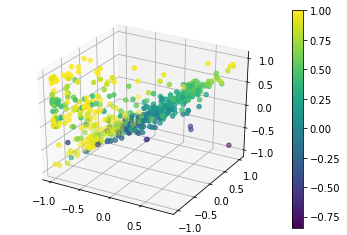

In [124]:
# 4D plot of conds
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = cms["GnEn"]
y = cms["GnEp"]
z = cms["GpEn"]
c = cms["GpEp"]

img = ax.scatter(x, y, z, c=c, cmap=plt.viridis())
fig.colorbar(img)
plt.show()
#fig.savefig('allsubs_4d_scatterplot.png')

## K-Means Clustering

In [125]:
km5 = KMeans(init='k-means++', n_clusters=5)
km5.fit(cms)
y_kmeans5 = km5.predict(cms)

In [126]:
y_kmeans5

array([0, 1, 1, 2, 4, 4, 3, 1, 4, 1, 2, 4, 4, 3, 4, 0, 4, 3, 4, 1, 2, 0,
       4, 0, 3, 1, 1, 4, 2, 1, 1, 1, 1, 2, 4, 3, 0, 2, 0, 2, 4, 2, 2, 4,
       0, 1, 4, 0, 1, 2, 3, 3, 3, 2, 3, 0, 4, 3, 3, 3, 3, 0, 0, 0, 3, 0,
       3, 0, 3, 2, 1, 0, 1, 2, 4, 0, 2, 0, 3, 1, 4, 3, 4, 3, 4, 1, 3, 1,
       2, 2, 4, 1, 3, 2, 2, 0, 2, 3, 2, 0, 2, 4, 4, 2, 3, 0, 0, 2, 3, 0,
       0, 4, 4, 1, 2, 0, 2, 0, 0, 3, 1, 3, 3, 0, 0, 3, 1, 3, 2, 1, 3, 3,
       3, 1, 3, 2, 1, 4, 1, 3, 0, 0, 4, 0, 3, 3, 2, 3, 2, 3, 3, 0, 3, 2,
       2, 0, 3, 3, 0, 0, 4, 2, 0, 2, 2, 2, 2, 1, 3, 0, 1, 4, 0, 3, 2, 0,
       0, 1, 4, 4, 3, 2, 3, 1, 0, 3, 0, 3, 0, 1, 0, 1, 3, 3, 4, 2, 0, 0,
       2, 0, 4, 0, 0, 3, 4, 0, 4, 3, 1, 3, 1, 2, 0, 1, 0, 0, 4, 0, 2, 0,
       4, 4, 3, 1, 4, 3, 1, 2, 1, 1, 4, 4, 4, 0, 2, 0, 3, 3, 3, 4, 2, 0,
       2, 4, 4, 2, 4, 1, 1, 1, 2, 0, 4, 0, 3, 2, 4, 2, 4, 2, 0, 4, 3, 3,
       0, 2, 2, 2, 3, 0, 4, 1, 4, 1, 0, 1, 3, 4, 1, 2, 0, 2, 4, 4, 0, 0,
       0, 2, 0, 2, 2, 3, 0, 0, 0, 3, 4, 3, 1, 0, 1,

## DF config and reordering

In [127]:
subList = thresh80[["sub"]]
#subList = comadj[["sub"]]
subList = subList.reset_index(drop=True)
cluster_model5 = pd.DataFrame(y_kmeans5, columns=['clust'])
clustList5 = pd.concat([subList, cluster_model5, cms], axis=1)

In [128]:
allDF = pd.concat([clustList5, rmet, ht], axis=1)
allDF.shape

(588, 8)

In [129]:
#allDF.to_csv('allDF.csv')

In [130]:
allHT = allDF.copy()
allHT = allHT.dropna()
allHT["ht"] = pd.to_numeric(allHT["ht"])
allHT.shape

(411, 8)

In [131]:
allHTE = pd.concat([clustList5, rmet, hte], axis=1)
allHTE = allHTE.dropna()
allHTE["ht"] = pd.to_numeric(allHTE["ht"])
allHTE.shape

(411, 10)

In [132]:
allHT

,sub,clust,GnEn,GnEp,GpEn,GpEp,rmet,ht
177,s204,1,-0.965517,-0.310345,-0.054545,0.844828,30,20.0
178,s205,4,-1.000000,-0.542373,0.883333,1.000000,36,20.0
179,s206,4,-0.916667,-0.813559,1.000000,1.000000,32,18.0
180,s207,3,0.240741,0.333333,0.259259,0.102041,13,0.0
181,s209,2,-1.000000,0.169492,-0.844828,0.783333,28,20.0
182,s210,3,0.610169,0.568966,0.566667,0.566667,11,0.0
183,s211,1,-0.733333,-0.423729,-0.050000,0.932203,29,18.0
184,s213,0,-0.051724,-0.220339,0.033333,-0.017544,12,14.0
185,s215,3,0.288136,0.203704,0.333333,0.206897,12,0.0
186,s216,0,0.220339,0.017544,0.050000,0.216667,10,4.0


In [133]:
# Means by cluster
clust0a = allHTE[allHTE["clust"] == 0]
rc0 = clust0a["WC_Avg"]
hc0 = clust0a["ht"]
c0_rmean = round(rc0.mean(),2)
c0_hmean = round(hc0.mean(),2)
clust1a = allHTE[allHTE["clust"] == 1]
rc1 = clust1a["WC_Avg"]
hc1 = clust1a["ht"]
c1_rmean = round(rc1.mean(),2)
c1_hmean = round(hc1.mean(),2)
clust2a = allHTE[allHTE["clust"] == 2]
rc2 = clust2a["WC_Avg"]
hc2 = clust2a["ht"]
c2_rmean = round(rc2.mean(),2)
c2_hmean = round(hc2.mean(),2)
clust3a = allHTE[allHTE["clust"] == 3]
rc3 = clust3a["rmet"]
hc3 = clust3a["ht"]
c3_rmean = round(rc3.mean(),2)
c3_hmean = round(hc3.mean(),2)
clust4a = allHTE[allHTE["clust"] == 4]
rc4 = clust4a["WC_Avg"]
hc4 = clust4a["ht"]
c4_rmean = round(rc4.mean(),2)
c4_hmean = round(hc4.mean(),2)

print("clust1: WC mean = " + str(c1_rmean) + ", ht mean = " + str(c1_hmean))
print("clust2: WC mean = " + str(c2_rmean) + ", ht mean = " + str(c2_hmean))
print("clust3: WC mean = " + str(c3_rmean) + ", ht mean = " + str(c3_hmean))
print("clust4: WC mean = " + str(c4_rmean) + ", ht mean = " + str(c4_hmean))
print("clust0: WC mean = " + str(c0_rmean) + ", ht mean = " + str(c0_hmean))

clust1: WC mean = 7.6, ht mean = 16.7
clust2: WC mean = 7.4, ht mean = 16.1
clust3: WC mean = 14.32, ht mean = 2.76
clust4: WC mean = 7.51, ht mean = 15.64
clust0: WC mean = 6.85, ht mean = 4.96


In [134]:
# Means by cluster
clust0 = allDF[allDF["clust"] == 0]
clust0a = allHT[allHT["clust"] == 0]
rc0 = clust0["rmet"]
hc0 = clust0a["ht"]
c0_rmean = round(rc0.mean(),2)
c0_hmean = round(hc0.mean(),2)
clust1 = allDF[allDF["clust"] == 1]
clust1a = allHT[allHT["clust"] == 1]
rc1 = clust1["rmet"]
hc1 = clust1a["ht"]
c1_rmean = round(rc1.mean(),2)
c1_hmean = round(hc1.mean(),2)
clust2 = allDF[allDF["clust"] == 2]
clust2a = allHT[allHT["clust"] == 2]
rc2 = clust2["rmet"]
hc2 = clust2a["ht"]
c2_rmean = round(rc2.mean(),2)
c2_hmean = round(hc2.mean(),2)
clust3 = allDF[allDF["clust"] == 3]
clust3a = allHT[allHT["clust"] == 3]
rc3 = clust3["rmet"]
hc3 = clust3a["ht"]
c3_rmean = round(rc3.mean(),2)
c3_hmean = round(hc3.mean(),2)
clust4 = allDF[allDF["clust"] == 4]
clust4a = allHT[allHT["clust"] == 4]
rc4 = clust4["rmet"]
hc4 = clust4a["ht"]
c4_rmean = round(rc4.mean(),2)
c4_hmean = round(hc4.mean(),2)
rmeansdict = {
  "0": c0_rmean,
  "1": c1_rmean,
  "2": c2_rmean,
  "3": c3_rmean,
  "4": c4_rmean
}
print("clust1: rmet mean = " + str(c1_rmean) + ", ht mean = " + str(c1_hmean))
print("clust2: rmet mean = " + str(c2_rmean) + ", ht mean = " + str(c2_hmean))
print("clust3: rmet mean = " + str(c3_rmean) + ", ht mean = " + str(c3_hmean))
print("clust4: rmet mean = " + str(c4_rmean) + ", ht mean = " + str(c4_hmean))
print("clust0: rmet mean = " + str(c0_rmean) + ", ht mean = " + str(c0_hmean))

clust1: rmet mean = 28.34, ht mean = 16.7
clust2: rmet mean = 27.15, ht mean = 16.1
clust3: rmet mean = 13.63, ht mean = 2.76
clust4: rmet mean = 26.51, ht mean = 15.64
clust0: rmet mean = 14.95, ht mean = 4.96


In [135]:
# Copy dictionary
rMeansDict = rmeansdict.copy()
origMeansList = list(rMeansDict.values())
newMeansList = []
newMeansDict = {}
compMeansDict = {}

for cm in range(len(origMeansList)):
    currMin = min(origMeansList)
    newMeansDict[cm] = currMin
    origNum = list(rMeansDict.values()).index(currMin)
    compMeansDict[origNum] = cm
    origMeansList.remove(currMin)

#print(rMeansDict)
#print(newMeansDict)
#print(compMeansDict)

In [136]:
#ordered_allDF = allDF.replace({"clust": compMeansDict})
clustList5 = clustList5.replace({"clust": compMeansDict})
clustList5["clust"] += 1
new_clusts = list(clustList5["clust"])
allDF = allDF.replace({"clust": compMeansDict})
allDF["clust"] += 1
allHT = allDF.copy()
allHT = allHT.dropna()
allHT["ht"] = pd.to_numeric(allHT["ht"])
#allDF.to_csv('allDF.csv')

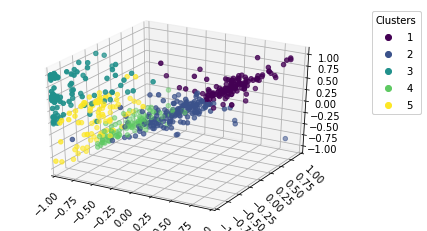

In [137]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = cms["GnEn"]
y = cms["GnEp"]
z = cms["GpEn"]
c = cms["GpEp"]

img = ax.scatter(x, y, z, c=new_clusts, cmap=plt.viridis())
legend1 = ax.legend(*img.legend_elements(), bbox_to_anchor=(1.25, 1), loc="upper right", title="Clusters")
ax.add_artist(legend1)
ax.tick_params(axis ='x', rotation =45)
ax.tick_params(axis ='y', rotation =-45)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
#plt.zlim(-1, 1)
#fig.colorbar(img)
plt.show()
#fig.savefig('figs/fig1_allsubs_kmeans_scatterplot.png', pad_inches=0.5, bbox_extra_artists=(legend1,), bbox_inches='tight')

### Avg Cluster Responses

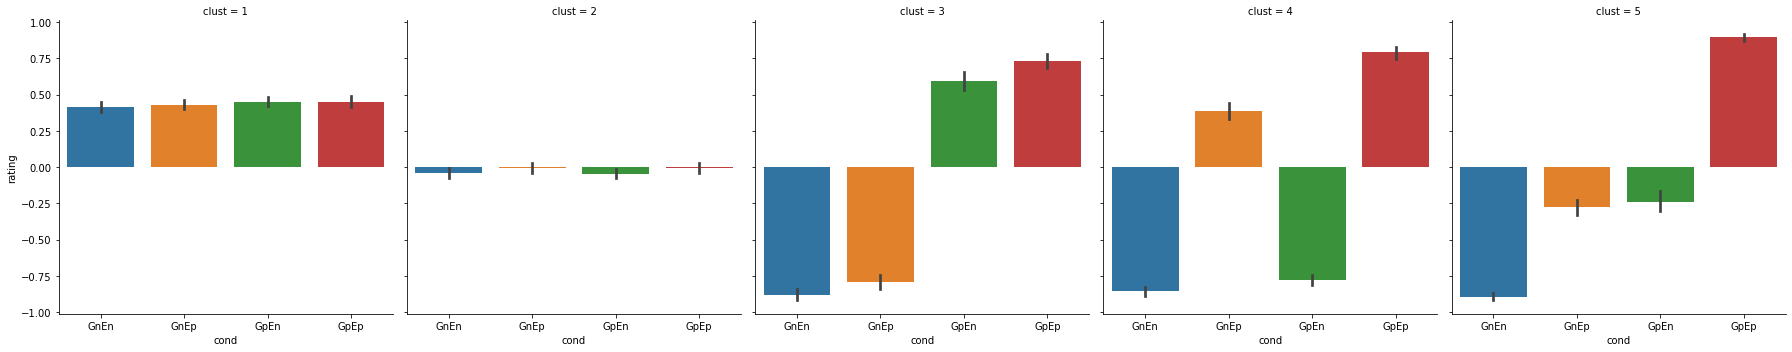

In [138]:
clst5_melt = pd.melt(clustList5,('sub','clust'),var_name='cond',value_name='rating')
g = sns.catplot(x="cond", y="rating", kind='bar', col="clust", col_wrap=5, data=clst5_melt)
#plt.savefig('5clust_conds_barplot.png')
plt.tight_layout()
#plt.savefig('figs/fig2_conds_barplot.png')

In [139]:
# Means by cluster
clust1 = allDF[allDF["clust"] == 1]
clust1a = allHT[allHT["clust"] == 1]
c1_num = len(clust1)
c1a_num = len(clust1a)
print("Number of c1-rmet subs: " + str(c1_num))
print("Number of c1-ht subs: " + str(c1a_num))
rc1 = clust1["rmet"]
hc1 = clust1a["ht"]
c1_rmean = round(rc1.mean(),2)
c1_hmean = round(hc1.mean(),2)
print("clust1: rmet mean = " + str(c1_rmean) + ", ht mean = " + str(c1_hmean))
###
clust2 = allDF[allDF["clust"] == 2]
clust2a = allHT[allHT["clust"] == 2]
c2_num = len(clust2)
c2a_num = len(clust2a)
print("Number of c2-rmet subs: " + str(c2_num))
print("Number of c2-ht subs: " + str(c2a_num))
rc2 = clust2["rmet"]
hc2 = clust2a["ht"]
c2_rmean = round(rc2.mean(),2)
c2_hmean = round(hc2.mean(),2)
print("clust2: rmet mean = " + str(c2_rmean) + ", ht mean = " + str(c2_hmean))
###
clust3 = allDF[allDF["clust"] == 3]
clust3a = allHT[allHT["clust"] == 3]
c3_num = len(clust3)
c3a_num = len(clust3a)
print("Number of c3-rmet subs: " + str(c3_num))
print("Number of c3-ht subs: " + str(c3a_num))
rc3 = clust3["rmet"]
hc3 = clust3a["ht"]
c3_rmean = round(rc3.mean(),2)
c3_hmean = round(hc3.mean(),2)
print("clust3: rmet mean = " + str(c3_rmean) + ", ht mean = " + str(c3_hmean))
###
clust4 = allDF[allDF["clust"] == 4]
clust4a = allHT[allHT["clust"] == 4]
c4_num = len(clust4)
c4a_num = len(clust4a)
print("Number of c4-rmet subs: " + str(c4_num))
print("Number of c4-ht subs: " + str(c4a_num))
rc4 = clust4["rmet"]
hc4 = clust4a["ht"]
c4_rmean = round(rc4.mean(),2)
c4_hmean = round(hc4.mean(),2)
print("clust4: rmet mean = " + str(c4_rmean) + ", ht mean = " + str(c4_hmean))
###
clust5 = allDF[allDF["clust"] == 5]
clust5a = allHT[allHT["clust"] == 5]
c5_num = len(clust5)
c5a_num = len(clust5a)
print("Number of c5-rmet subs: " + str(c5_num))
print("Number of c5-ht subs: " + str(c5a_num))
rc5 = clust5["rmet"]
hc5 = clust5a["ht"]
c5_rmean = round(rc5.mean(),2)
c5_hmean = round(hc5.mean(),2)
print("clust5: rmet mean = " + str(c5_rmean) + ", ht mean = " + str(c5_hmean))
###
print("Total # of rmet subs: " + str(sum([c1_num,c2_num,c3_num,c4_num,c5_num])))
print("Total # of ht subs: " + str(sum([c1a_num,c2a_num,c3a_num,c4a_num,c5a_num])))
rmeansdict = {
  "1": c1_rmean,
  "2": c2_rmean,
  "3": c3_rmean,
  "4": c4_rmean,
  "5": c5_rmean
}

Number of c1-rmet subs: 131
Number of c1-ht subs: 87
clust1: rmet mean = 13.63, ht mean = 2.76
Number of c2-rmet subs: 150
Number of c2-ht subs: 110
clust2: rmet mean = 14.95, ht mean = 4.96
Number of c3-rmet subs: 101
Number of c3-ht subs: 73
clust3: rmet mean = 26.51, ht mean = 15.64
Number of c4-rmet subs: 115
Number of c4-ht subs: 78
clust4: rmet mean = 27.15, ht mean = 16.1
Number of c5-rmet subs: 91
Number of c5-ht subs: 63
clust5: rmet mean = 28.34, ht mean = 16.7
Total # of rmet subs: 588
Total # of ht subs: 411


In [140]:
rnonstrat = allDF.loc[(allDF["clust"] == 1) | (allDF["clust"] == 2), "rmet"]
rstrat = allDF.loc[(allDF["clust"] == 3) | (allDF["clust"] == 4) | (allDF["clust"] == 5), "rmet"]
hnonstrat = allDF.loc[(allDF["clust"] == 1) | (allDF["clust"] == 2), "ht"]
hstrat = allDF.loc[(allDF["clust"] == 3) | (allDF["clust"] == 4) | (allDF["clust"] == 5), "ht"]

In [141]:
print("Non-strategy, RMET")
print(rnonstrat.mean())
print(rnonstrat.std())
print("Strategy, RMET")
print(rstrat.mean())
print(rstrat.std())
print("Non-strategy, HT")
print(hnonstrat.mean())
print(hnonstrat.std())
print("Strategy, HT")
print(hstrat.mean())
print(hstrat.std())

Non-strategy, RMET
14.330960854092528
4.858064223745252
Strategy, RMET
27.293159609120522
5.638226102154546
Non-strategy, HT
3.989847715736041
6.179285547265997
Strategy, HT
16.121495327102803
4.783010387175399


In [142]:
print(allDF["rmet"].max())
print(allDF["rmet"].mean())
print(allDF["rmet"].std())
print(allDF["rmet"].min())

37
21.098639455782312
8.356033932802141
5


In [143]:
print(allHT["ht"].max())
print(allHT["ht"].mean())
print(allHT["ht"].std())
print(allHT["ht"].min())

20.0
10.306569343065693
8.182875078073149
0.0


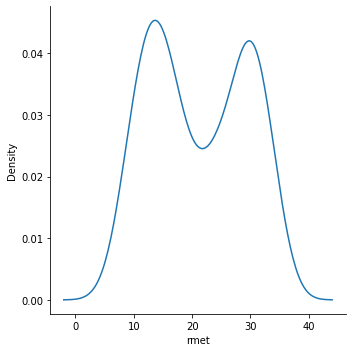

In [144]:
g = sns.displot(data=allDF, x="rmet", kind="kde")

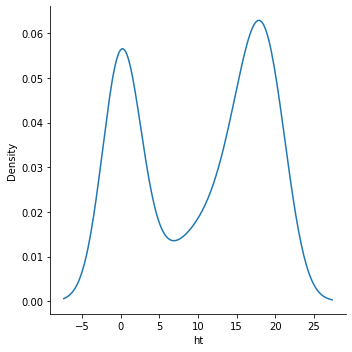

In [145]:
g = sns.displot(data=allHT, x="ht", kind="kde")

In [151]:
allDF

,sub,clust,GnEn,GnEp,GpEn,GpEp,rmet,ht
0,s001,2,-0.017544,0.050000,0.033898,0.071429,8,NaN
1,s002,5,-0.933333,-0.310345,0.016667,1.000000,32,NaN
2,s003,5,-0.964286,-0.224138,-0.385965,0.933333,30,NaN
3,s004,4,-0.803922,0.750000,-0.791667,0.562500,15,NaN
4,s005,3,-0.933333,-0.736842,0.677966,0.800000,34,NaN
5,s006,3,-0.895833,-0.942308,0.420000,0.407407,21,NaN
6,s008,1,0.362069,0.350877,0.357143,0.464286,12,NaN
7,s009,5,-0.762712,-0.203390,-0.533333,0.633333,24,NaN
8,s010,3,-0.542373,-0.508475,0.525424,0.542373,20,NaN
9,s011,5,-0.833333,-0.200000,0.166667,0.916667,31,NaN


In [159]:
subInfo = allDF.iloc[:,:2]
contraG_maxVal_byClust = pd.concat([subInfo,maxCol_contraG], axis=1)
contraG_maxVal_byClust.columns = ["sub", "clust", "maxVal"]
contraE_maxVal_byClust = pd.concat([subInfo,maxCol_contraE], axis=1)
contraE_maxVal_byClust.columns = ["sub", "clust", "maxVal"]

In [162]:
contraE_maxVal_byClust

,sub,clust,maxVal
0,s001,2,0.0
1,s002,5,0.0
2,s003,5,0.0
3,s004,4,1.0
4,s005,3,-1.0
5,s006,3,-1.0
6,s008,1,0.0
7,s009,5,0.0
8,s010,3,-1.0
9,s011,5,0.0


In [167]:
contraG_int = contraG_maxVal_byClust[contraG_maxVal_byClust["clust"] == 5]

In [168]:
contraE_int = contraE_maxVal_byClust[contraE_maxVal_byClust["clust"] == 5]

In [217]:
contraGint_counts = contraG_int["maxVal"].value_counts()
contraGint_counts

 0.0    51
-1.0    35
 1.0     5
Name: maxVal, dtype: int64

In [218]:
contraEint_counts = contraE_int["maxVal"].value_counts()
contraEint_counts

 0.0    56
-1.0    29
 1.0     6
Name: maxVal, dtype: int64

In [179]:
contraG_obs = contraG_int["maxVal"]
contraG_obs.reset_index(inplace=True, drop=True)

In [183]:
contraG_obs.shape

(91,)

In [191]:
listA = [-1] * 30
listB = [0] * 31
listC = [1] * 30
listA = pd.Series(listA)
listB = pd.Series(listB)
listC = pd.Series(listC)
contra_exp = pd.concat([listA,listB,listC])
contra_exp.reset_index(inplace=True, drop=True)

In [194]:
contra_exp.size

91

In [216]:
#contraConds = 
contraGint_counts.shape

(3,)

In [234]:
d = {'Not_Aware': [35, 29, 30, 36], 'Somewhat_Aware': [51, 56, 31, 19], 'Very_Aware': [5, 6, 30, 36]}
contraConds = pd.DataFrame(data=d)
contraConds

,Not_Aware,Somewhat_Aware,Very_Aware
0,35,51,5
1,29,56,6
2,30,31,30
3,40,11,40


In [226]:
sp.stats.chisquare(contraConds.iloc[0], f_exp=contraConds.iloc[2])

Power_divergenceResult(statistic=34.56989247311828, pvalue=3.113459562320304e-08)

In [227]:
sp.stats.chisquare(contraConds.iloc[1], f_exp=contraConds.iloc[2])

Power_divergenceResult(statistic=39.394623655913975, pvalue=2.789755643407025e-09)

In [235]:
sp.stats.chisquare(contraConds.iloc[0], f_exp=contraConds.iloc[3])

Power_divergenceResult(statistic=176.70454545454547, pvalue=4.2569200229981996e-39)

In [236]:
sp.stats.chisquare(contraConds.iloc[1], f_exp=contraConds.iloc[3])

Power_divergenceResult(statistic=216.0159090909091, pvalue=1.2380589933474927e-47)

In [238]:
contraG_maxVal_byClust["maxVal"].value_counts()

 0.0    210
-1.0    193
 1.0    185
Name: maxVal, dtype: int64

In [239]:
contraE_maxVal_byClust["maxVal"].value_counts()

 0.0    237
 1.0    177
-1.0    174
Name: maxVal, dtype: int64

In [240]:
dx = {'Not_Aware': [193, 177, 196, 235], 'Somewhat_Aware': [210, 237, 196, 118], 'Very_Aware': [185, 174, 196, 235]}
contraConds_allSubs = pd.DataFrame(data=dx)
contraConds_allSubs

,Not_Aware,Somewhat_Aware,Very_Aware
0,193,210,185
1,177,237,174
2,196,196,196
3,235,118,235


In [241]:
sp.stats.chisquare(contraConds.iloc[0], f_exp=contraConds.iloc[2])

Power_divergenceResult(statistic=34.56989247311828, pvalue=3.113459562320304e-08)

In [242]:
sp.stats.chisquare(contraConds.iloc[0], f_exp=contraConds.iloc[3])

Power_divergenceResult(statistic=176.70454545454547, pvalue=4.2569200229981996e-39)

In [243]:
sp.stats.chisquare(contraConds.iloc[1], f_exp=contraConds.iloc[2])

Power_divergenceResult(statistic=39.394623655913975, pvalue=2.789755643407025e-09)

In [244]:
sp.stats.chisquare(contraConds.iloc[1], f_exp=contraConds.iloc[3])

Power_divergenceResult(statistic=216.0159090909091, pvalue=1.2380589933474927e-47)